<a href="https://colab.research.google.com/github/saenuruki/YouTube-watch-count-Prediction/blob/master/YouTubePrediction_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [51]:
#環境確認
!python3 --version

import pandas as pd
print("pandas: " + pd.__version__)

import numpy as np
print("numpy: " + np.__version__)

import sklearn
print("sklearn: " + sklearn.__version__)

import matplotlib
print("matplotlib: " + matplotlib.__version__)

Python 3.6.9
pandas: 1.0.3
numpy: 1.18.3
sklearn: 0.22.2.post1
matplotlib: 3.2.1


In [52]:
#Google Driveと連携する
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### データのロード

In [53]:
#データの読み込みと前処理
train_data = pd.read_csv("/content/drive/My Drive/train_data.csv", index_col='id')
print(train_data.shape)

(19720, 16)


In [54]:
(train_data['likes'] / train_data['y']).describe()

count    19720.000000
mean         0.005018
std          0.011937
min          0.000000
25%          0.001294
50%          0.002900
75%          0.005783
max          1.240741
dtype: float64

In [55]:
train_data.head()

,video_id,title,publishedAt,channelId,channelTitle,categoryId,collection_date,tags,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,description,y
id,,,,,,,,,,,,,,,,
1,GDtyztIThRQ,[12] BGM Inazuma Eleven 3 - ~ライオコツト ダンジョン~,2011-01-09T05:50:33.000Z,UCQaNYC3dNvH8FqrEyK7hTJw,DjangoShiny,20,20.01.02,Inazuma|Eleven|Super|Once|bgm|ost|イナズマイレブン|Kyo...,114,0,7,https://i.ytimg.com/vi/GDtyztIThRQ/default.jpg,False,False,~ライオコツト ダンジョン~Inazuma Eleven 3 BGM Complete (R...,29229
2,m4H9s3GtTlQ,ねごと - メルシールー [Official Music Video],2012-07-23T03:00:09.000Z,UChMWDi-HBm5aS3jyRSaAWUA,ねごと Official Channel,10,20.08.02,ねごと|ネゴト|メルシールー|Re:myend|リマインド|Lightdentity|ライデ...,2885,50,111,https://i.ytimg.com/vi/m4H9s3GtTlQ/default.jpg,False,False,http://www.negoto.com/全員平成生まれ、蒼山幸子（Vo＆Key)、沙田瑞...,730280
3,z19zYZuLuEU,VF3tb 闇よだれvsちび太 (SEGA),2007-07-26T13:54:09.000Z,UCBdcyoZSt5HBLd_n6we-xIg,siropai,24,20.14.01,VF3|VF4|VF5|ちび太|闇よだれ|chibita|virtuafighter|seg...,133,17,14,https://i.ytimg.com/vi/z19zYZuLuEU/default.jpg,False,False,Beat-tribe cup finalhttp://ameblo.jp/siropai/,80667
4,pmcIOsL7s98,free frosty weekend!,2005-05-15T02:38:43.000Z,UC7K5am1UAQEsCRhzXpi9i1g,Jones4Carrie,22,19.22.12,frosty,287,51,173,https://i.ytimg.com/vi/pmcIOsL7s98/default.jpg,False,False,I look so bad but look at me!,34826
5,ZuQgsTcuM-4,トップ・オブ・ザ・ワールド,2007-09-09T09:52:47.000Z,UCTW1um4R-QWa8iIfITGvlZQ,Tatsuya Maruyama,10,20.08.01,ギター|guitar|南澤大介|トップオブザワールド|トップ|オブ|ワールド|カーペンターズ...,178,6,17,https://i.ytimg.com/vi/ZuQgsTcuM-4/default.jpg,False,False,ソロギターのしらべより「トップオブザワールド」です。クラシックギターで弾いてます。Offic...,172727


### データの確認と前処理

(array([1.9624e+04, 5.4000e+01, 1.3000e+01, 8.0000e+00, 6.0000e+00,
        4.0000e+00, 4.0000e+00, 2.0000e+00, 0.0000e+00, 3.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([2.00000000e+00, 1.07128023e+08, 2.14256043e+08, 3.21384064e+08,
        4.28512085e+08, 5.35640106e+08, 6.42768126e+08, 7.49896147e+08,
        8.57024168e+08, 9.64152188e+08, 1.07128021e+09, 1.17840823e+09,
        1.28553625e+09, 1.39266427e+09, 1.49979229e+09, 1.60692031e+09,
        1.71404833e+09, 1.82117635e+09, 1.92830437e+09, 2.03543240e+09,
        2.14256042e+09]),
 <a list of 20 Patch objects>)

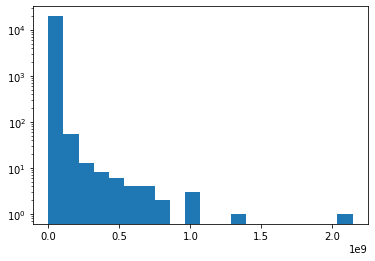

In [56]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.hist(train_data['y'], bins=20, log=True)

(array([1.684e+04, 1.220e+03, 5.270e+02, 2.360e+02, 1.710e+02, 1.070e+02,
        8.000e+01, 6.300e+01, 6.100e+01, 3.600e+01, 2.700e+01, 3.800e+01,
        2.900e+01, 1.200e+01, 1.900e+01, 1.100e+01, 1.600e+01, 4.000e+00,
        1.100e+01, 1.400e+01]),
 array([2.0000000e+00, 2.8219590e+06, 5.6439160e+06, 8.4658730e+06,
        1.1287830e+07, 1.4109787e+07, 1.6931744e+07, 1.9753701e+07,
        2.2575658e+07, 2.5397615e+07, 2.8219572e+07, 3.1041529e+07,
        3.3863486e+07, 3.6685443e+07, 3.9507400e+07, 4.2329357e+07,
        4.5151314e+07, 4.7973271e+07, 5.0795228e+07, 5.3617185e+07,
        5.6439142e+07]),
 <a list of 20 Patch objects>)

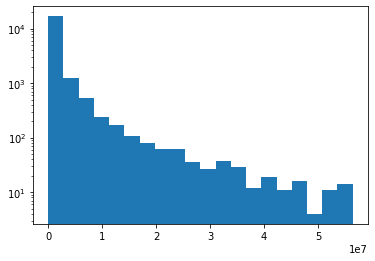

In [57]:
#外れ値除外
#回帰モデルに悪影響を及ぼす恐れのある上位1%を除去する
train_data = train_data[train_data["y"] < np.percentile(train_data['y'], 99)]
train_data.reset_index(drop=True)
plt.hist(train_data['y'], bins=20, log=True)

In [58]:
#欠損値以外(non-null)の含有率の確認
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19522 entries, 1 to 19720
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   video_id           19522 non-null  object
 1   title              19522 non-null  object
 2   publishedAt        19522 non-null  object
 3   channelId          19522 non-null  object
 4   channelTitle       19522 non-null  object
 5   categoryId         19522 non-null  int64 
 6   collection_date    19522 non-null  object
 7   tags               19521 non-null  object
 8   likes              19522 non-null  int64 
 9   dislikes           19522 non-null  int64 
 10  comment_count      19522 non-null  int64 
 11  thumbnail_link     19522 non-null  object
 12  comments_disabled  19522 non-null  bool  
 13  ratings_disabled   19522 non-null  bool  
 14  description        19210 non-null  object
 15  y                  19522 non-null  int64 
dtypes: bool(2), int64(5), object(9)
memory u

In [0]:
#Object -> Int64
train_data['publishedAt'] =  pd.to_datetime(train_data['publishedAt']).map(pd.Timestamp.to_julian_date)

In [60]:
#数値データの正規化
#平均0、標準偏差1になるように変換を行う
l = ['likes', 'dislikes', 'comment_count', 'publishedAt']
for name in l:
    mean = np.nanmean(train_data[name], axis=0)
    std = np.nanstd(train_data[name], axis=0)
    train_data[name] = (train_data[name] - mean)/std
train_data.describe()

,publishedAt,categoryId,likes,dislikes,comment_count,y
count,1.952200e+04,19522.000000,1.952200e+04,1.952200e+04,1.952200e+04,1.952200e+04
mean,7.646334e-14,15.910306,-2.751388e-17,-6.533764e-17,3.703397e-16,1.803871e+06
std,1.000026e+00,8.684912,1.000026e+00,1.000026e+00,1.000026e+00,4.918672e+06
min,-1.605412e+00,1.000000,-2.900779e-01,-2.214770e-01,-2.411631e-01,2.000000e+00
25%,-9.378234e-01,10.000000,-2.872672e-01,-2.195250e-01,-2.398220e-01,6.824225e+04
50%,-2.145848e-02,17.000000,-2.680869e-01,-2.053736e-01,-2.254058e-01,3.058175e+05
75%,9.248891e-01,24.000000,-1.403091e-01,-1.302243e-01,-1.342151e-01,1.255392e+06
max,1.754030e+00,44.000000,2.605187e+01,3.817687e+01,3.574564e+01,5.643914e+07


### 予測モデルの作成/学習

In [0]:
#使用する説明変数・目的変数を代入
model_input = train_data[['categoryId', 'likes', 'dislikes', 'comment_count', 'publishedAt', 'y']]

#説明変数・目的変数についてnull値を含むレコードを除外
model_input = model_input.dropna(how='any', axis=0) 

# 目的変数と説明変数を代入
X = model_input[['categoryId', 'likes', 'dislikes', 'comment_count', 'publishedAt']]
y = np.log(model_input['y'])

In [0]:
# one hot表現へ変換
X = pd.get_dummies(X, columns=['categoryId'], drop_first=True)

In [63]:
#scikit-learnライブラリをimport
from sklearn.linear_model import LinearRegression as LR

#線形回帰モデルのインスタンス化
#LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
model = LR()

#予測モデルの作成
model.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [64]:
#切片
model.intercept_
#model.coef_で係数の一覧、.intercept_で切片を見ることができます。

12.623831394358584

In [65]:
#各説明変数の係数対応表
coeff = pd.DataFrame(X.columns)
coeff.columns = ['説明変数']
coeff['係数推定'] = model.coef_
print(coeff)

#各説明変数の係数を比較することで、どの説明変数がどれほどの影響を与えていたか把握することができます。
#各説明変数は、係数の値が正に大きいほど視聴回数に対して正の寄与をしており、反対に負に大きいほど視聴回数に対して負の寄与をしていると言えます。

             説明変数      係数推定
0           likes  0.579694
1        dislikes  0.363648
2   comment_count  0.051812
3     publishedAt  0.409643
4    categoryId_2 -0.512656
5   categoryId_10  0.370962
6   categoryId_15 -0.924757
7   categoryId_17 -0.400887
8   categoryId_19 -1.671840
9   categoryId_20 -0.051330
10  categoryId_22 -0.647365
11  categoryId_23  0.035074
12  categoryId_24 -0.064332
13  categoryId_25 -0.956726
14  categoryId_26 -0.516795
15  categoryId_27 -0.442606
16  categoryId_28 -1.333004
17  categoryId_29 -1.998885
18  categoryId_30 -6.530386
19  categoryId_44  1.004041


### モデルの評価

In [66]:
#決定係数
#1に近いほど回帰式で予測された値が実際のデータに当てはまることを表します。
model.score(X,y)

0.28001797307587306

In [67]:
# RMSLE値の出力
from sklearn.metrics import mean_squared_log_error
y_true = model_input['y']
y_pred = np.exp(model.predict(X))
print(np.sqrt(mean_squared_log_error(y_true, y_pred)))

1.9462134377385298


### テストデータに対する出力

In [68]:
test_data = pd.read_csv("/content/drive/My Drive/test_data.csv", index_col='id')
test_data.head()

,video_id,title,publishedAt,channelId,channelTitle,categoryId,collection_date,tags,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,description
id,,,,,,,,,,,,,,,
1,xU8UcB6RbLE,Frightened Rabbit - The Greys,2007-09-26T11:00:07.000Z,UCOQ_j8Qg4-p0lGKBpXYENbg,Fatcat Records,10,20.08.01,Fatcat|Records|Frightened|Rabbit|The|Greys,471,38,61,https://i.ytimg.com/vi/xU8UcB6RbLE/default.jpg,False,False,Director: Fraser CampbellDate:2007Taken from F...
2,ENuB3qHCp0s,Eダンスアカデミー『EXダンス体操（EXILEのダンス体操）』,2016-05-27T15:00:00.000Z,UCip8ve30-AoX2y2OtAAmqFA,NHK,24,20.09.02,Ｅダンス|Ｅアカ|EXILE|EXダンス体操|ダンス体操|EX体操|エクササイズ、GENER...,6797,666,0,https://i.ytimg.com/vi/ENuB3qHCp0s/default.jpg,True,False,EXILEがダンスを楽しく分かりやすくレッスンする「Eダンスアカデミー」毎週金曜日に放送中！...
3,2eIeMPhXhSQ,『Lover Come Back To Me』 大西由希子×川口千里(Senri Kawag...,2012-12-10T08:24:57.000Z,UCZyaEXqC4i3ni68duKOg6JA,atossinternational,10,20.03.02,大西由希子|岩永真奈|川口千里|教則|長崎祥子|ジャズ|ユッコミラー|atossintern...,3371,111,212,https://i.ytimg.com/vi/2eIeMPhXhSQ/default.jpg,False,False,教則DVD『アドリブ・サックス・パーフェクト・マスター』収録の究極のギャルバンによるスタジオ...
4,yXfmnY6QIOc,konnkonn雛たち大きくなりました☆,2012-02-27T05:23:46.000Z,UCyeDXVF4epn-ed3c3ckyhOQ,cpj54293,15,20.02.02,オカメインコひな,508,16,23,https://i.ytimg.com/vi/yXfmnY6QIOc/default.jpg,False,False,オカメインコのひなたち約生後３９日です鳴き声が変わりましたジィージィーの中にピィッ！ピィッ！...
5,dGbHHMKYGkw,"Anouk - Everything, Live cover by RU kiddin me",2007-11-24T15:18:04.000Z,UCnOICsYtfygl--dfI9kclVQ,Vinzarelli,10,20.10.01,Anouk|Everything|live|cover|tribute,0,1,0,https://i.ytimg.com/vi/dGbHHMKYGkw/default.jpg,False,False,Anouk tribute band RU kiddin me covers Everyth...


In [0]:
test_data['publishedAt'] =  pd.to_datetime(test_data['publishedAt']).map(pd.Timestamp.to_julian_date)

In [70]:
l = ['likes', 'dislikes', 'comment_count', 'publishedAt']
for name in l:
    mean = np.nanmean(test_data[name], axis=0)
    std = np.nanstd(test_data[name], axis=0)
    test_data[name] = (test_data[name] - mean)/std
test_data.describe()

,publishedAt,categoryId,likes,dislikes,comment_count
count,2.958200e+04,29582.000000,2.958200e+04,2.958200e+04,2.958200e+04
mean,-1.052652e-13,15.863667,-1.240533e-16,1.780731e-16,3.154502e-16
std,1.000017e+00,8.670842,1.000017e+00,1.000017e+00,1.000017e+00
min,-1.611338e+00,1.000000,-1.391489e-01,-6.680798e-02,-1.563839e-01
25%,-9.275596e-01,10.000000,-1.382193e-01,-6.639529e-02,-1.557679e-01
50%,-2.663144e-02,17.000000,-1.322320e-01,-6.391913e-02,-1.485304e-01
75%,9.177797e-01,24.000000,-9.205591e-02,-5.005267e-02,-1.052589e-01
max,1.750811e+00,44.000000,6.588549e+01,1.369860e+02,7.579106e+01


In [0]:
#使用する説明変数・目的変数を代入
model_input_test = test_data[['categoryId', 'likes', 'dislikes', 'comment_count', 'publishedAt']]

#説明変数・目的変数についてnull値を含むレコードを除外
model_input_test = model_input_test.dropna(how='any', axis=0) 

# 目的変数と説明変数を代入
X_test = model_input_test

In [0]:
# one hot表現へ変換
X_test = pd.get_dummies(X_test, columns=['categoryId'], drop_first=True)

In [0]:
#訓練データとテストデータで共通する列名のみに、モデルの説明変数を絞り込む
col_list = X.columns.tolist() 
col_test_list = X_test.columns.tolist()
col_joint = col_list + col_test_list
col_dup = [x for x in set(col_joint) if col_joint.count(x) > 1]

In [78]:
#訓練データの説明変数の中で、テストデータと共通しない列名を抽出
col_list_p = [x for x in set(col_joint) if col_list.count(x) == 0]
print(col_list_p)

['categoryId_43']


In [82]:
#共通の説明変数のみに学習、テストデータのカラムを統一
X_test =X_test.drop('categoryId_43',axis=1)

X_train_fix = X[col_dup]
X_test_fix = X_test[col_dup]

#予測モデルの作成
model.fit(X_train_fix, y)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [0]:
#テスト結果の出力
test_predicted = np.exp(model.predict(X_test_fix))
submit_df = pd.DataFrame({'y': test_predicted})
submit_df.index.name = 'id'
submit_df.to_csv('submission.csv')

In [84]:
#出力ファイルをローカルにダウンロード
!ls

from google.colab import files
files.download('submission.csv')

drive  sample_data  submission.csv


### 誤差の大きなデータの確認

(array([3.200e+01, 8.820e+02, 5.119e+03, 7.204e+03, 3.960e+03, 1.487e+03,
        5.660e+02, 1.920e+02, 5.900e+01, 1.400e+01, 3.000e+00, 0.000e+00,
        2.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00]),
 array([-5.95858436, -4.32620805, -2.69383174, -1.06145543,  0.57092088,
         2.20329719,  3.8356735 ,  5.46804981,  7.10042612,  8.73280243,
        10.36517874, 11.99755505, 13.62993136, 15.26230767, 16.89468398,
        18.52706029, 20.1594366 , 21.79181291, 23.42418922, 25.05656553,
        26.68894184]),
 <a list of 20 Patch objects>)

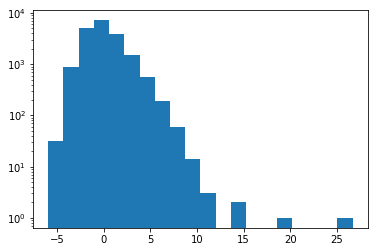

In [0]:
plt.hist(np.log(y_pred+1) - np.log(y_true+1), log=True, bins=20)

In [0]:
#誤差の絶対値が15を超えるデータの一覧
threshold = 15
wrong_idx_lower = np.where(np.log(y_pred+1) - np.log(y_true+1) > threshold)[0]
print(wrong_idx_lower)

[ 3361  4658 10206]


In [0]:
train_data.loc[wrong_idx_lower, :]
#視聴回数を過大に評価したデータは3つ。 過小に評価したデータはありませんでした。

,video_id,title,publishedAt,channelId,channelTitle,categoryId,collection_date,tags,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,description,y
id,,,,,,,,,,,,,,,,
3361,E1Nyg03z0pQ,H.R. GIGER,-1.429517,UCT0R2PJweieLDNNJhyNx4HA,fuzzedoutmama,1,19.30.12,GIGER,-0.250120,-0.206837,-0.143602,https://i.ytimg.com/vi/E1Nyg03z0pQ/default.jpg,False,False,giger,349785
4658,b-griRtKHLU,スチャダラパーとEGO-WRAPPIN' ミクロボーイとマクロガール（Official Mu...,1.172165,UCQZDh-m6a31o7rXJPuMiFbA,SPACE SHOWER MUSIC,10,20.09.02,スチャダラパー|schadaraparr|Bose|ANI|SHINCO|ラップグループ|今...,0.219213,0.091808,-0.023579,https://i.ytimg.com/vi/b-griRtKHLU/default.jpg,False,False,スチャダラパーとEGO-WRAPPIN’によるコラボ曲「ミクロボーイとマクロガール」のミュー...,2383295
10206,PPJBp5naSf8,[びじゅチューン！] 兵馬俑ウエディング | NHK,1.272681,UCip8ve30-AoX2y2OtAAmqFA,NHK,24,20.09.02,井上涼|びじゅチューン！|びじゅチューン|アニメ|美術|兵馬俑ウエディング|兵馬俑|始皇帝|...,-0.251909,-0.195614,-0.241163,https://i.ytimg.com/vi/PPJBp5naSf8/default.jpg,True,False,NHKサイトで全作公開中！どーがレージ＞＞https://www.nhk.or.jp/d-g...,382571
